In [ ]:
# %%capture
# !pip install tensorflow_text==2.6.0

In [1]:
import os 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

from numpy import newaxis
from wordcloud import WordCloud, STOPWORDS

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import xgboost as xgb
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Activation, GRU, BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
use = hub.load(module_url)

In [4]:
import pandas as pd
df_reviews = pd.read_csv("/content/final_preprocessed_nlp_data (4).csv")
df_reviews = df_reviews[["text", "sentiment"]]
df_reviews

,text,sentiment
0,last night here are some of scotts best lines ...,Positive
1,hours after her debate above any of the men ...,Positive
2,highest ratings in the history of presidential...,Positive
3,i will rescind every illegal executive action ...,Positive
4,happy when i heard she was going to be the mod...,Negative
...,...,...
10724,will never be faced with a pregnancy talk abou...,Negative
10725,expectations \n\ngopdebate imwithhuck gop cco...,Positive
10726,always tell the truth and do what i said i wou...,Positive
10727,he doesnt have time for political correctness ...,Negative


In [5]:
def preprocess(sentiment):
  if sentiment == 'Negative':return 0
  if sentiment == 'Positive':return 1
  if sentiment == 'Neutral':return 2

df_reviews["label"] = df_reviews["sentiment"].apply(preprocess)
df_reviews

,text,sentiment,label
0,last night here are some of scotts best lines ...,Positive,1
1,hours after her debate above any of the men ...,Positive,1
2,highest ratings in the history of presidential...,Positive,1
3,i will rescind every illegal executive action ...,Positive,1
4,happy when i heard she was going to be the mod...,Negative,0
...,...,...,...
10724,will never be faced with a pregnancy talk abou...,Negative,0
10725,expectations \n\ngopdebate imwithhuck gop cco...,Positive,1
10726,always tell the truth and do what i said i wou...,Positive,1
10727,he doesnt have time for political correctness ...,Negative,0


In [6]:
!pip install text_hammer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import text_hammer as th

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


In [8]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

CPU times: user 578 µs, sys: 0 ns, total: 578 µs
Wall time: 589 µs


In [9]:
df_cleaned = text_preprocessing(df_reviews,'text')

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

In [10]:
df_reviews["label"] = df_reviews["sentiment"].apply(
    lambda x: 1 if x == 'Positive' or x == 'Neutral' else 0)

In [11]:
df_cleaned

,text,sentiment,label
0,last night here are some of scotts best lines ...,Positive,1
1,hours after her debate above any of the men in...,Positive,1
2,highest ratings in the history of presidential...,Positive,1
3,i will rescind every illegal executive action ...,Positive,1
4,happy when i heard she was going to be the mod...,Negative,0
...,...,...,...
10724,will never be faced with a pregnancy talk abou...,Negative,0
10725,expectations gopdebate imwithhuck gop ccot tea...,Positive,1
10726,always tell the truth and do what i said i wou...,Positive,1
10727,he doesnt have time for political correctness ...,Negative,0


In [12]:
positive_reviews = df_reviews[df_reviews.sentiment == "Positive"]
ne_reviews = df_reviews[df_reviews.sentiment == "Negative"]

In [13]:
positive_reviews = " ".join(positive_reviews.sentiment.to_numpy().tolist())
ne_reviews = " ".join(ne_reviews.sentiment.to_numpy().tolist())

In [14]:
label_enc = preprocessing.LabelEncoder()
encoded_review = label_enc.fit_transform(df_cleaned.sentiment.values)

In [15]:
train_reviews, test_reviews, y_train, y_test = train_test_split(
    df_cleaned.sentiment, 
    encoded_review, 
    test_size=0.25, 
    random_state=RANDOM_SEED
  )

In [16]:
X_train = []
for r in tqdm(train_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 8046/8046 [03:09<00:00, 42.46it/s]


In [17]:
X_test = []
for r in tqdm(test_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 2683/2683 [00:51<00:00, 52.59it/s]


In [18]:
print(X_train.shape, X_test.shape)

(8046, 512) (2683, 512)


In [19]:
print(y_train.shape, y_test.shape)

(8046,) (2683,)


In [20]:
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy= history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot_model(model):
    model.summary()
    return tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    )

In [21]:
y_train.shape

(8046,)

In [22]:
newaxis

In [23]:
X_train_reshaped = X_train[:, newaxis,:]
X_test_reshaped = X_test[:, newaxis,:]

In [24]:
X_train_reshaped.shape

(8046, 1, 512)

In [25]:
# input_shape
1,X_train_reshaped.shape[2]

(1, 512)

In [26]:
X_train_reshaped.shape[2]

512

In [27]:
def build_model_lstm():
    model = Sequential()
    model.add(LSTM(256, activation='relu', return_sequences=True,
                 input_shape=(1,X_train_reshaped.shape[2])))
    model.add(LSTM(128, dropout=0.2, activation='relu', return_sequences=True))
    model.add(LSTM(64, dropout=0.2, activation='relu',  return_sequences=True))
    model.add(Dense(2, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
    return model

In [28]:
model_lstm = build_model_lstm()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 256)            787456    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
dense (Dense)                (None, 1, 2)              130       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              3         
Total params: 1,034,117
Trainable params: 1,034,117
Non-trainable params: 0
_________________________________________________________________


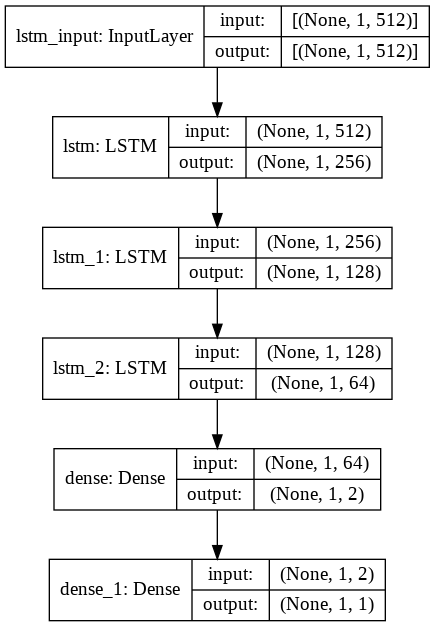

In [29]:
plot_model(model_lstm)

In [30]:
X_train_reshaped.shape, y_train.shape

((8046, 1, 512), (8046,))

In [31]:
%%time
history = model_lstm.fit(
    X_train_reshaped, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
453/453 [==============================] - 11s 17ms/step - loss: 0.3494 - accuracy: 0.9416 - val_loss: 0.2746 - val_accuracy: 1.0000
Epoch 2/10
453/453 [==============================] - 13s 28ms/step - loss: 0.2473 - accuracy: 1.0000 - val_loss: 0.2287 - val_accuracy: 1.0000
Epoch 3/10
453/453 [==============================] - 6s 13ms/step - loss: 0.2078 - accuracy: 1.0000 - val_loss: 0.1942 - val_accuracy: 1.0000
Epoch 4/10
453/453 [==============================] - 6s 14ms/step - loss: 0.1772 - accuracy: 1.0000 - val_loss: 0.1664 - val_accuracy: 1.0000
Epoch 5/10
453/453 [==============================] - 6s 14ms/step - loss: 0.1521 - accuracy: 1.0000 - val_loss: 0.1432 - val_accuracy: 1.0000
Epoch 6/10
453/453 [==============================] - 13s 28ms/step - loss: 0.1311 - accuracy: 1.0000 - val_loss: 0.1237 - val_accuracy: 1.0000
Epoch 7/10
453/453 [==============================] - 7s 14ms/step - loss: 0.1133 - accuracy: 1.0000 - val_loss: 0.1070 - val_accuracy: 1.0

In [32]:
# plot_history(history)

In [33]:
model_lstm.evaluate(X_test_reshaped, y_test)

84/84 [==============================] - 1s 6ms/step - loss: 0.0680 - accuracy: 1.0000


[0.06804538518190384, 1.0]

In [34]:
model_lstm.save("lstm_sentiment_model4.h5")

In [35]:
model_lstm.save("lstm_sentiment_model4")

In [36]:
imported_model1 = tf.keras.models.load_model('/content/lstm_sentiment_model4')


imported_model1.summary()
imported_model1.evaluate(X_test_reshaped, y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 256)            787456    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
dense (Dense)                (None, 1, 2)              130       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              3         
Total params: 1,034,117
Trainable params: 1,034,117
Non-trainable params: 0
_________________________________________________________________
84/84 [==============================] - 1s 4ms/step - loss: 0.0680 - accuracy: 1.0000


[0.06804538518190384, 1.0]

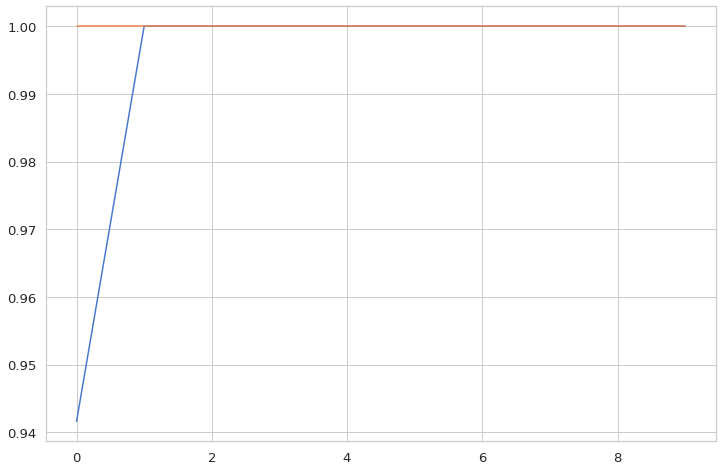

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

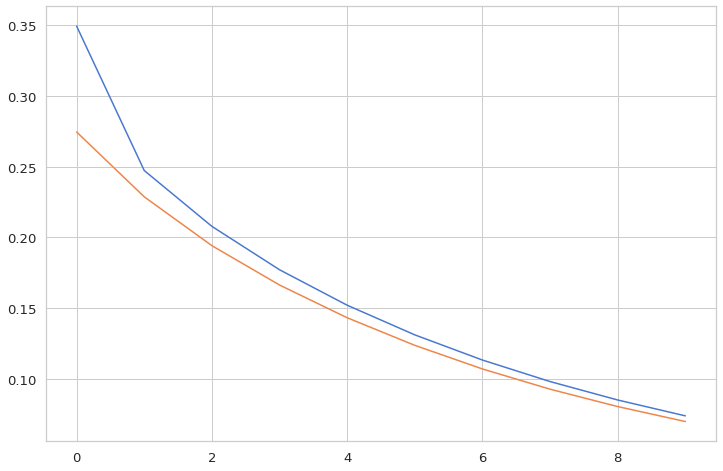

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])